In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from transformers import CLIPModel, CLIPTokenizer
import sys
import os
sys.path.append(os.path.abspath('/home/user/dxc/motion/StableMoFusion/'))
from motion_loader import get_dataset_loader  
from tqdm import tqdm
import random
import yaml
from argparse import Namespace
from model import *


In [2]:

with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

opt = Namespace(**config)


print(opt.batch_size)  
print(opt.lr)          
print(opt.device)      

32
0.0001
cuda


In [3]:
sys.path.append(os.path.abspath('/home/user/dxc/motion/StableMoFusion'))
train_loader = get_dataset_loader(
        opt,
        batch_size=opt.batch_size,
        split='train',
        mode='train'
    )
test_loader = get_dataset_loader(
    opt,
    batch_size=opt.batch_size,
    split='test',
    mode='gt_eval'
)


 Loading train mode HumanML3D dataset ...
11111111111111


  0%|          | 0/23384 [00:00<?, ?it/s]

Completing loading t2m dataset

 Loading gt_eval mode HumanML3D dataset ...
11111111111111


  0%|          | 0/4384 [00:00<?, ?it/s]

Completing loading t2m dataset


In [ ]:

clip_model = CLIPModel.from_pretrained(opt.clip_model_name)
clip_tokenizer = CLIPTokenizer.from_pretrained(opt.clip_model_name)


for name, param in clip_model.named_parameters():
    if "text_model" in name:
        param.requires_grad = False


motion_encoder = MotionEncoder(
    input_dim=opt.input_dim,
    embed_dim=opt.embed_dim,
    num_heads=8,
    num_layers=4,         
    dim_feedforward=2048,
    dropout=0.2,
    max_seq_length=opt.max_seq_length
)
model = ClipMotionAlignModel(
    clip_model=clip_model,
    motion_encoder=motion_encoder,
    temperature=0.07
).to(opt.device)

In [5]:
model_path = '/home/user/dxc/motion/StableMoFusion/MoCLIP/clip_motion_align_epoch_16.pt'
device = opt.device
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

ClipMotionAlignModel(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=Tru

In [6]:
import gc
gc.collect()

106

In [ ]:
import numpy as np

motions = []
torch.cuda.empty_cache()


for batch_data in test_loader:
    torch.cuda.empty_cache()  
    caption, motion, m_length = batch_data


    caption = [c.lower() for c in caption]
    text_enc = clip_tokenizer(
        caption,
        padding=True,
        truncation=True,
        max_length=opt.max_length,
        return_tensors="pt"
    )
    input_ids = text_enc["input_ids"].to(opt.device)
    attention_mask = text_enc["attention_mask"].to(opt.device)

    
    if isinstance(motion, list):
        motion = torch.stack([torch.tensor(m, dtype=torch.float32) for m in motion], dim=0)
    else:
        motion = motion.float()
    motion = motion.to(opt.device)  
    m_length = m_length.to(opt.device)

    
    with torch.no_grad():
        motion_emb, text_emb = model(motion, m_length, input_ids, attention_mask)

    
    motions.append(motion_emb.cpu().numpy())  

    # 清理缓存并删除不再需要的变量
    del motion_emb
    del text_emb
    torch.cuda.empty_cache()

# 将所有的motion_emb拼接成一个numpy数组
motions_cat = np.concatenate(motions, axis=0)  # 在第一个维度拼接，形成n*768

print(motions_cat.shape)

# 清理motions列表，释放内存
del motions
torch.cuda.empty_cache()

(4640, 768)


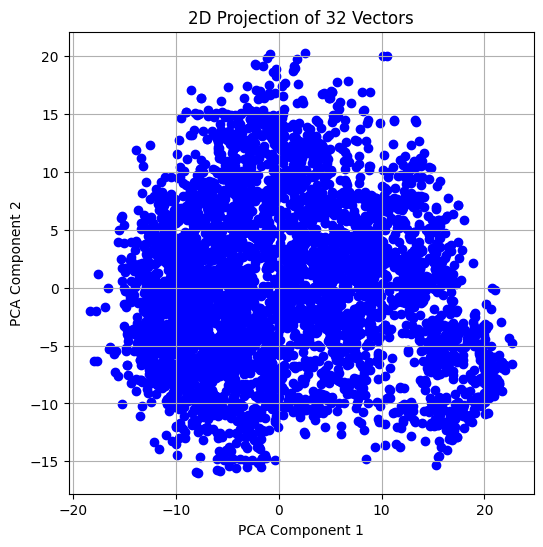

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



# 转换为numpy数组进行PCA
batch_data_np = motions_cat
# 使用PCA将数据降到二维
pca = PCA(n_components=2)
data_2d = pca.fit_transform(batch_data_np)

# 绘制二维散点图
plt.figure(figsize=(6, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', marker='o')
plt.title('2D Projection of 32 Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

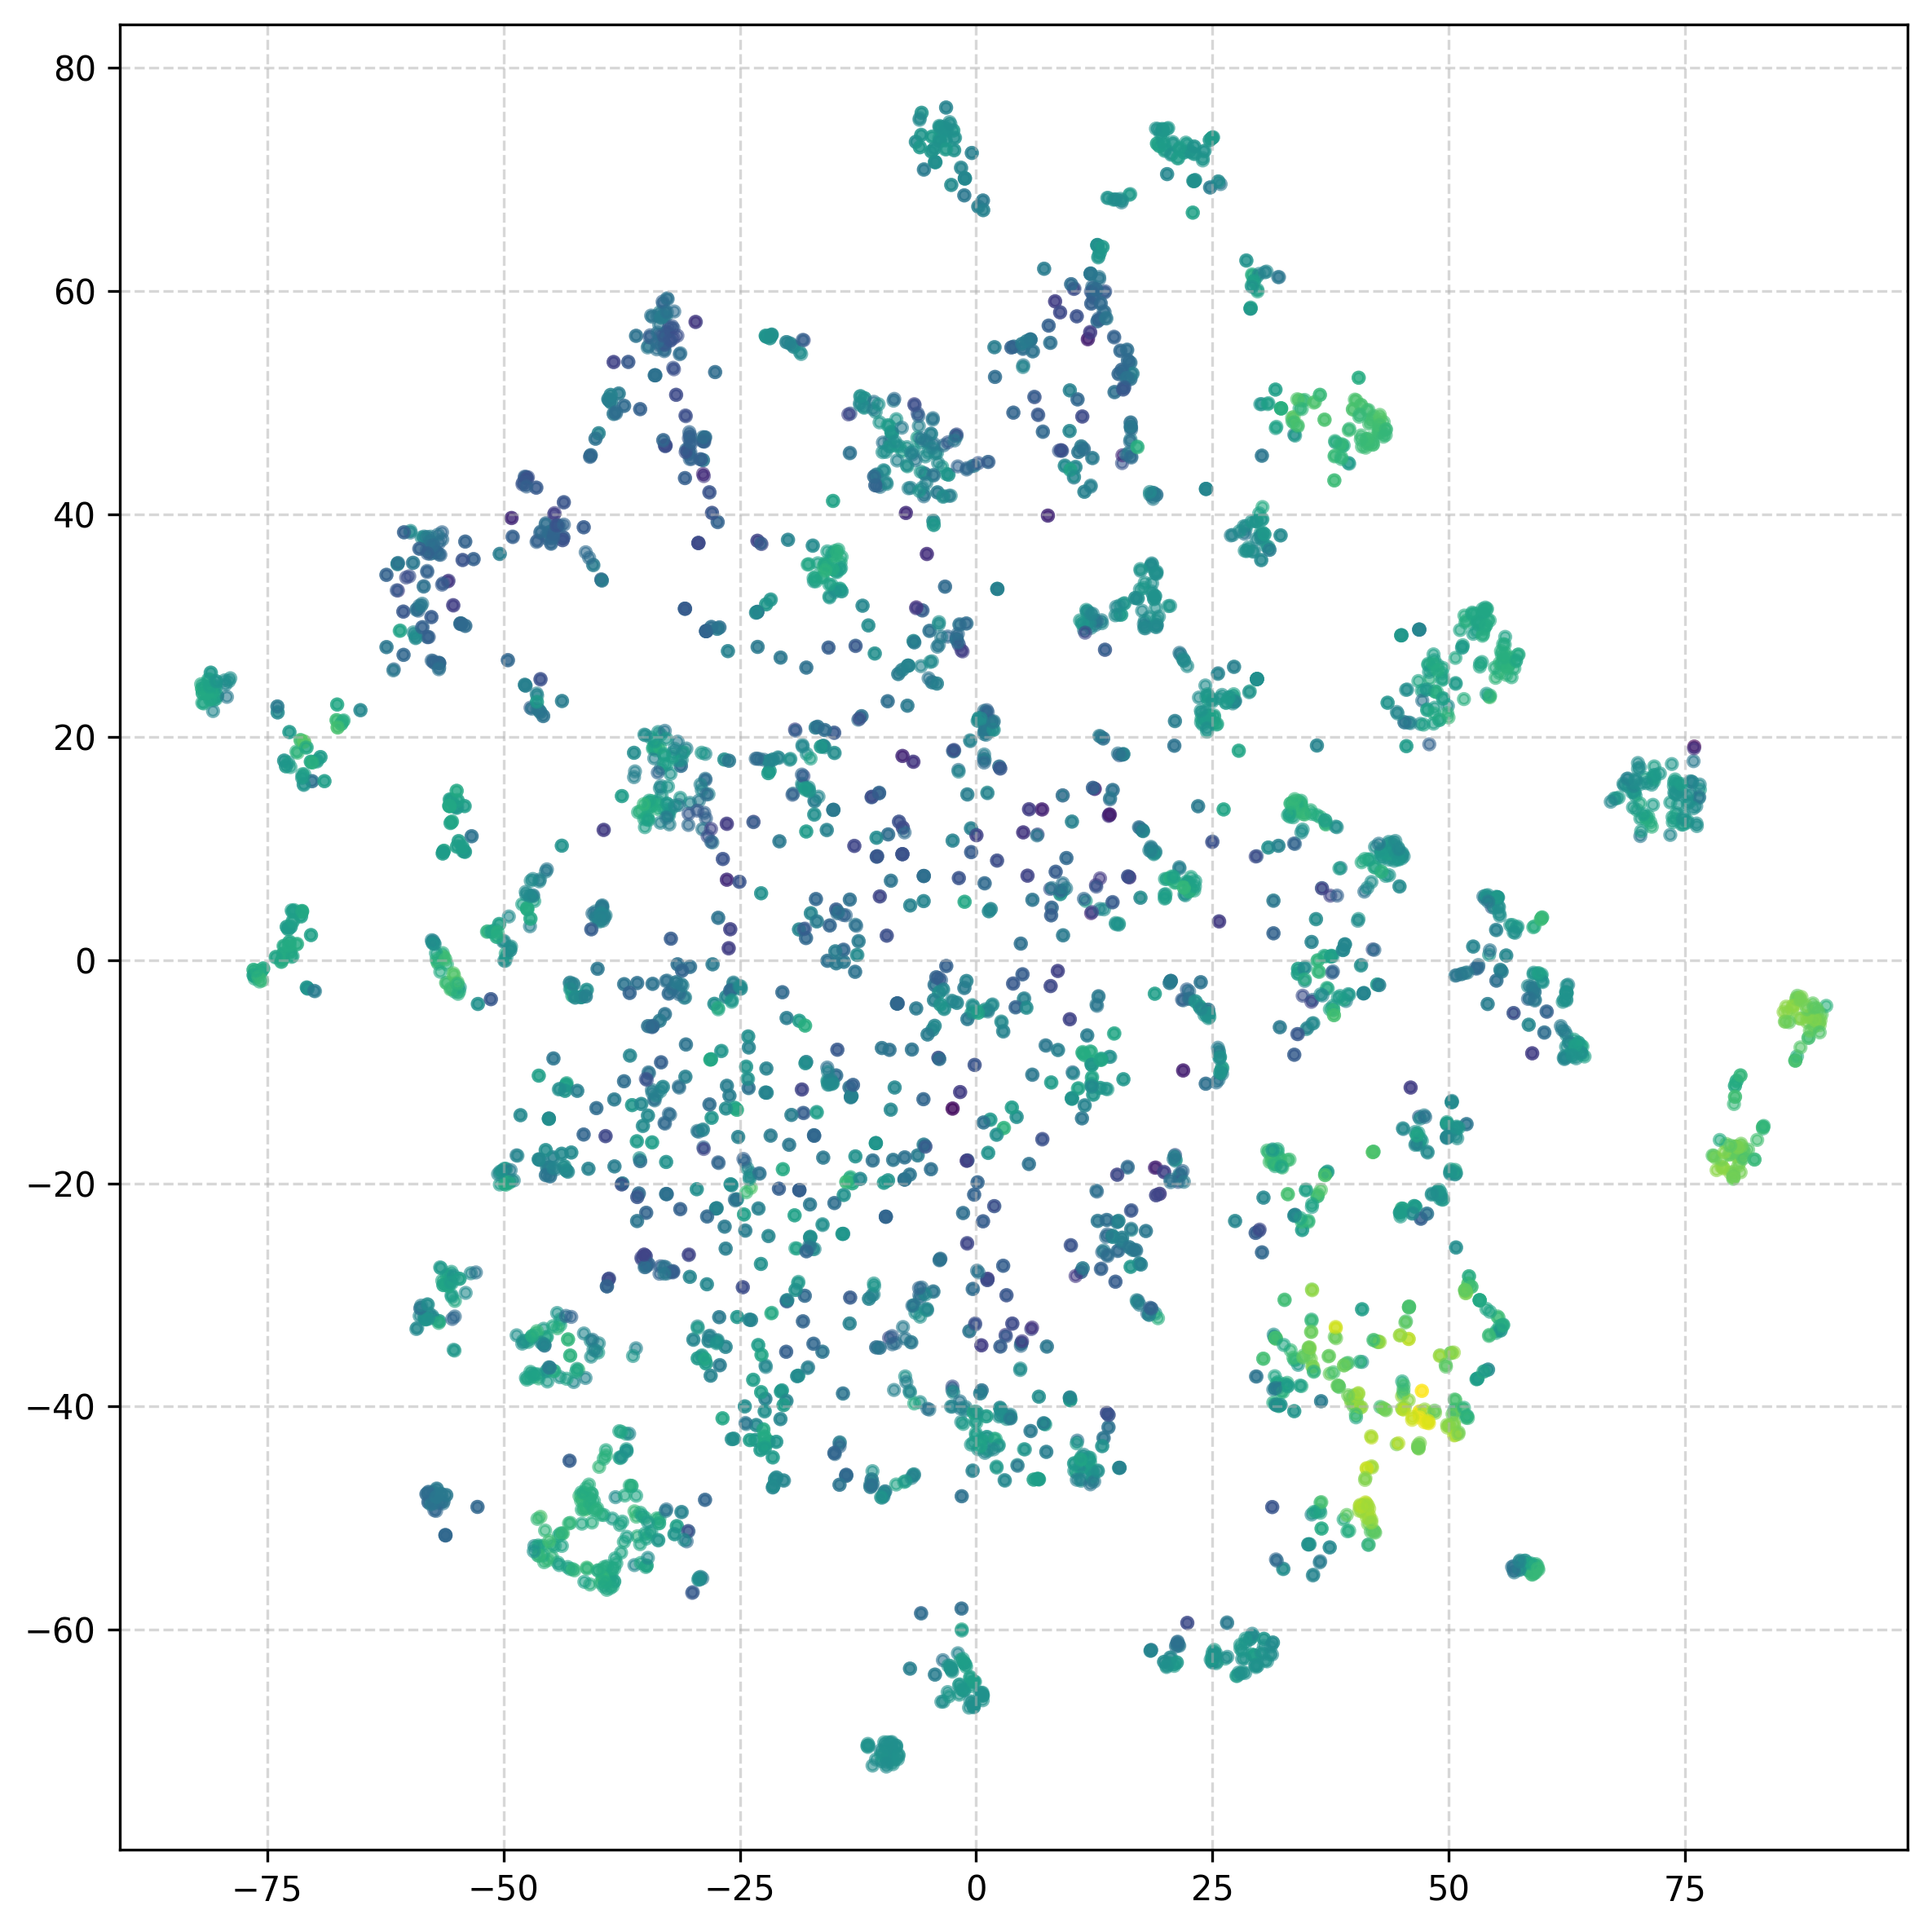

In [38]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 batch_data_np 是你的数据
tsne = TSNE(n_components=2, random_state=42)
data_2d_tsne = tsne.fit_transform(batch_data_np)

# 使用渐变色（例如：viridis）来表示每个点的不同
plt.figure(figsize=(8, 8), dpi=300)  # 提高分辨率
scatter = plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=np.linalg.norm(batch_data_np, axis=1), cmap='viridis', marker='o', alpha=0.6, s=10)

# 添加颜色条
#plt.colorbar(scatter, label='Vector Magnitude')

# plt.title('t-SNE Projection of all Vectors', fontsize=16)
# plt.xlabel('t-SNE Component 1', fontsize=14)
# plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)  # 设置淡灰色的网格线
plt.tight_layout()  # 自动调整布局以避免标签重叠
plt.show()

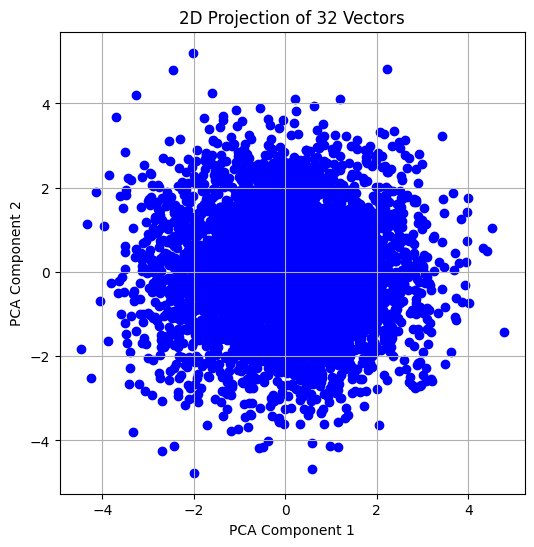

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 假设你有一个batch数据
batch_data = torch.randn(4640, 768)  # 这里用随机数生成32个1x768维度的向量

# 转换为numpy数组进行PCA
batch_data_np = batch_data.numpy()

# 使用PCA将数据降到二维
pca = PCA(n_components=2)
data_2d = pca.fit_transform(batch_data_np)

# 绘制二维散点图
plt.figure(figsize=(6, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', marker='o')
plt.title('2D Projection of 32 Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

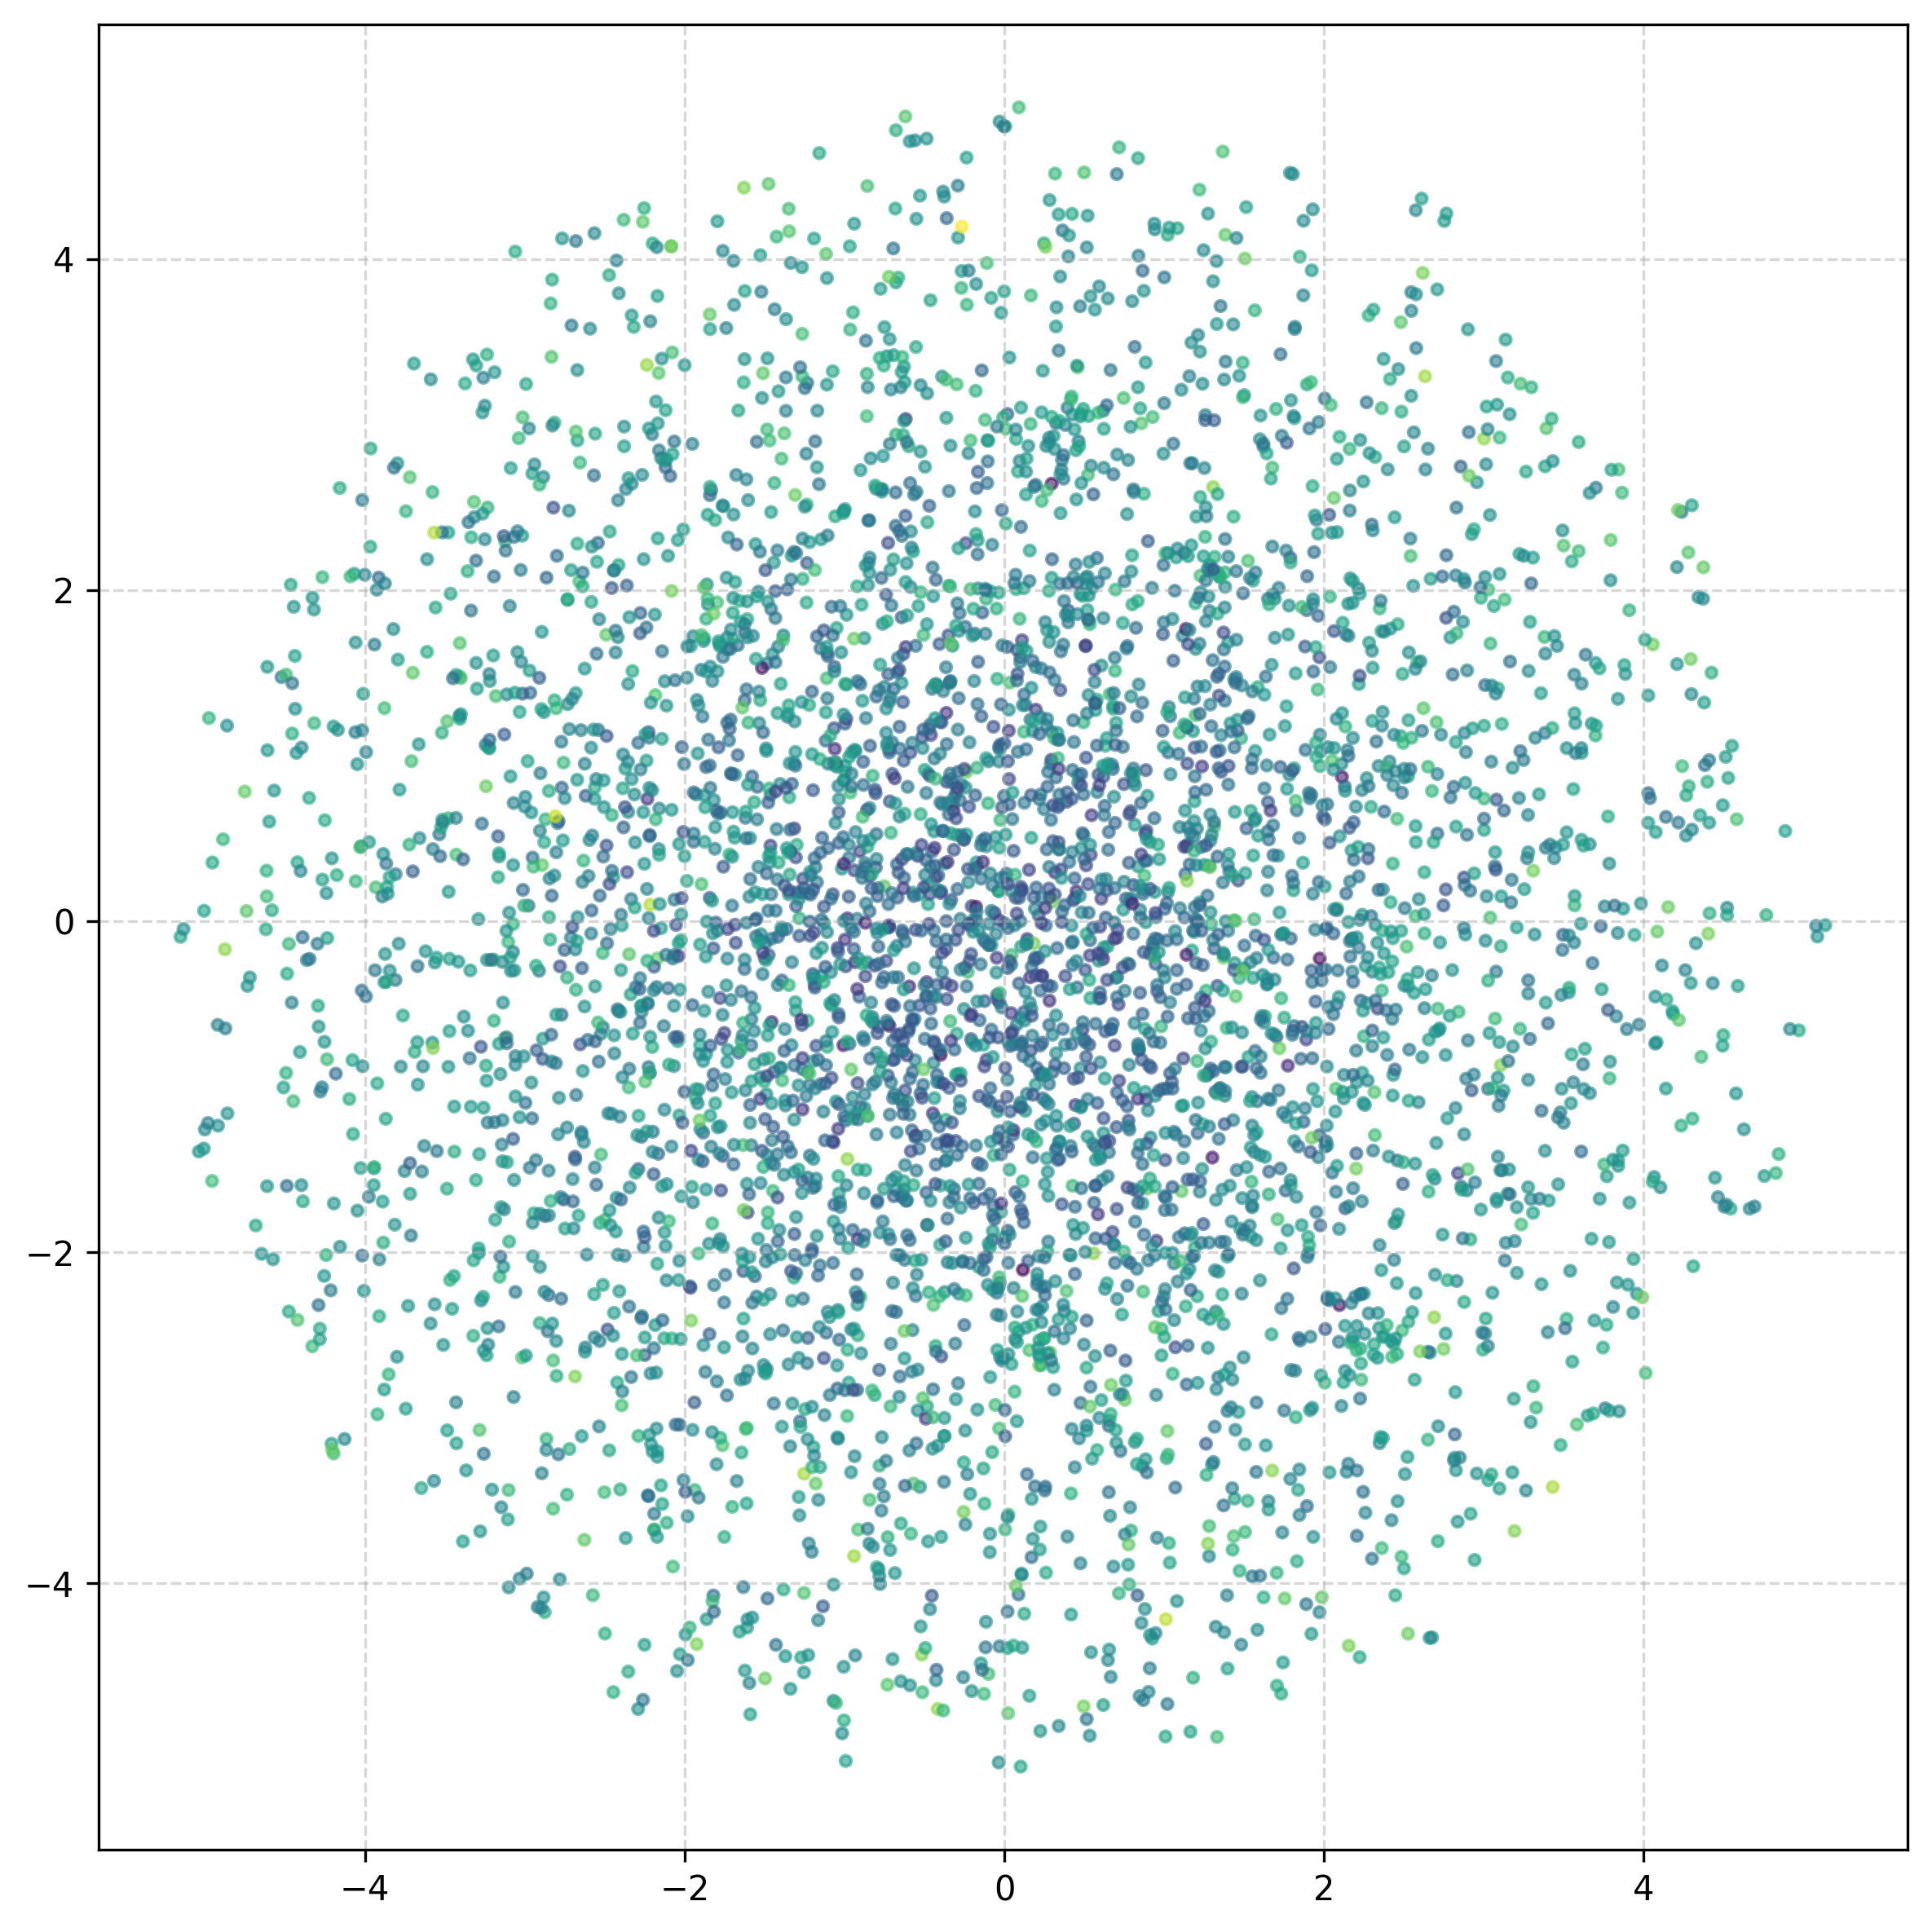

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 batch_data_np 是你的数据
tsne = TSNE(n_components=2, random_state=42)
data_2d_tsne = tsne.fit_transform(batch_data_np)

# 使用渐变色（例如：viridis）来表示每个点的不同
plt.figure(figsize=(8, 8), dpi=300)  # 提高分辨率
scatter = plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=np.linalg.norm(batch_data_np, axis=1), cmap='viridis', marker='o', alpha=0.6, s=10)

# 添加颜色条
#plt.colorbar(scatter, label='Vector Magnitude')

# plt.title('t-SNE Projection of all Vectors', fontsize=16)
# plt.xlabel('t-SNE Component 1', fontsize=14)
# plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)  # 设置淡灰色的网格线
plt.tight_layout()  # 自动调整布局以避免标签重叠
plt.show()